# Part 1


Python Coding and Data Set

Load in the data file and header file provided
The dataframe does not currently have a header, load in the header file and attach it to the dataframe
Comment on any steps you might take to evaluate or transform the dataset.
Compute the mean and median smoothness and compactness for benign and malignant tumors - 
do they differ? Explain how you would identify this.
Write a function to generate bootstrap samples of the data.
Exploratory Analysis
Identify 2-3 variables that are predictive of a malignant tumor.
Display the relationship visually and write 1-2 sentences explaining the relationship.
Modeling
Build a model to predict the malignant tumors.


Use at least two classification techniques; compare and contrast the advantages and disadvantages of each.
Identify how you would control for overfitting in each classification technique.
Evaluate the performance of each model.
In each model, identify the most important predictive variables and explain how you identified them.
Explanation

To Technical Audiences
Explain the limitations of your analysis and identify possible further steps you could take.
To Non-Technical Audiences
Write a short summary of your analysis, explaining how your model works and how it performs.
Briefly explain the factors that contributed to malignant vs benign tumor identification.


In [1]:
# import needed libraries and reading data
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
import pprint as pp
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


with open("field_names.txt") as file:
    col = file.read().splitlines()  # reading columns names which stored in field_names.txt on the currant directory
df = pd.read_csv("breast-cancer.csv",names=col) # reading data_file which stored in breast-cancer.csv on the currant directory 

In [2]:
"""
get full view of the data (data types and nulls)
and check classes value counts
"""
print(df.diagnosis.value_counts(),"\n"*3)

df.info()

B    357
M    212
Name: diagnosis, dtype: int64 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
ID                            569 non-null int64
diagnosis                     569 non-null object
radius_mean                   569 non-null float64
radius_sd_error               569 non-null float64
radius_worst                  569 non-null float64
texture_mean                  569 non-null float64
texture_sd_error              569 non-null float64
texture_worst                 569 non-null float64
perimeter_mean                569 non-null float64
perimeter_sd_error            569 non-null float64
perimeter_worst               569 non-null float64
area_mean                     569 non-null float64
area_sd_error                 569 non-null float64
area_worst                    569 non-null float64
smoothness_mean               569 non-null float64
smoothness_sd_error           569 non-null float64
smoothness_worst              

In [3]:
def boxplot_custom(df, subtitle = "Values of all col in boxplt" ):
    """
    this function return a box_plot for every feature with separation of diagnosis
    
    this function will be used for visualizing the distribution of the features values to determine if the data needs to be scaled.
    """
    fig, ax = plt.subplots()
    plt.style.use('seaborn-poster')
    fig.set_size_inches(18, 8)
    chart = sns.boxenplot(data = pd.melt(df.iloc[:,1:],id_vars="diagnosis"),x= "variable" , y= "value",scale=  "linear" ,color="B", hue= "diagnosis")
    sns.despine()
    plt.title ("Values of all col in boxplt")
    plt.suptitle(subtitle)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

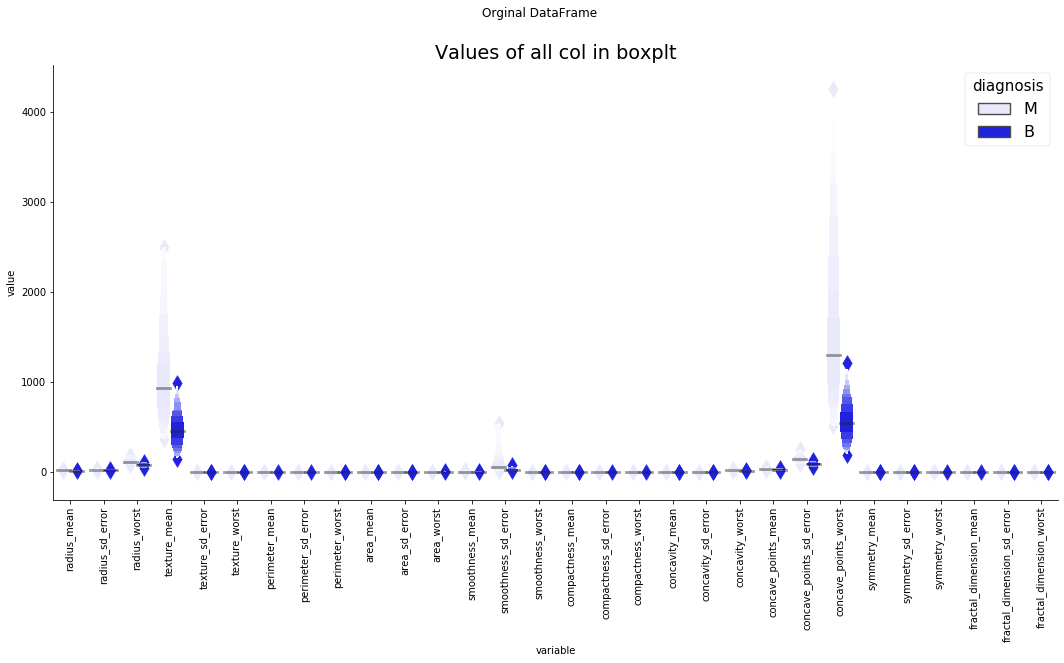

In [4]:
boxplot_custom(df, "Orginal DataFrame")

### It doesn't look smooth for that I'd scale all featuers








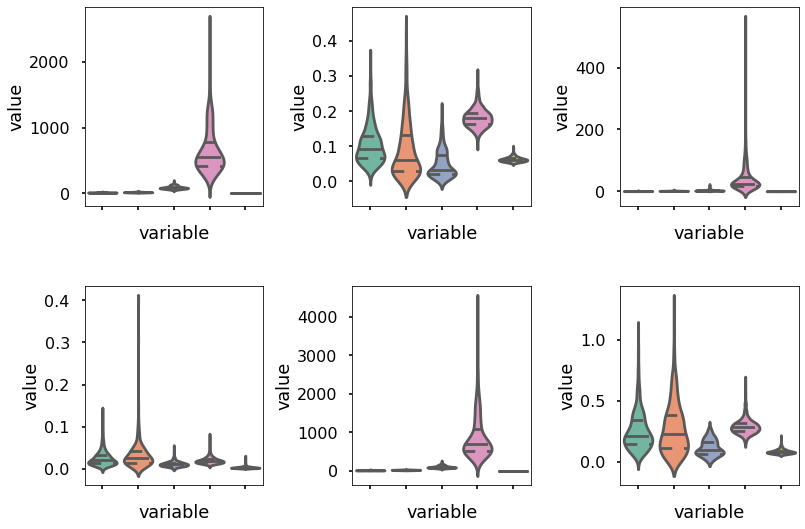

In [5]:
"""In this set of plots I'm trying to show the distribution of each feature to decide the best scaling algorithm 

. standard normalization is not recommended if the data follow normal distribution
. using a single algorithm makes all features on same scale


"""

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.5)

for i in range(6):
    ax = fig.add_subplot(2, 3, i+1)

    chart = sns.violinplot(x="variable", y="value",
                         data=df.iloc[:,(i*5)+2:(i+1)*5+2].melt(
    value_name='value'), palette="Set2", split=True,
                        scale="count", inner="quartile")# DataFrame.melt() change the structure of the dataset to become like Variable/s-value/s to simplify visulization
    chart.set_xticklabels("");

### I'll examin the standered scaller and rebust scaller.

In [6]:
def scale(df, scaler=RobustScaler):
    """the output of this function is features scaled of input DataFrame"""
    s = scaler() 
    scaled_df = pd.DataFrame(s.fit_transform(df.iloc[:,2:]),columns=df.iloc[:,2:].columns) # scaling the whole features
    return df.iloc[:,:2].join(scaled_df)# join the scaled features to the diagnosis and ID from the original DataFrame

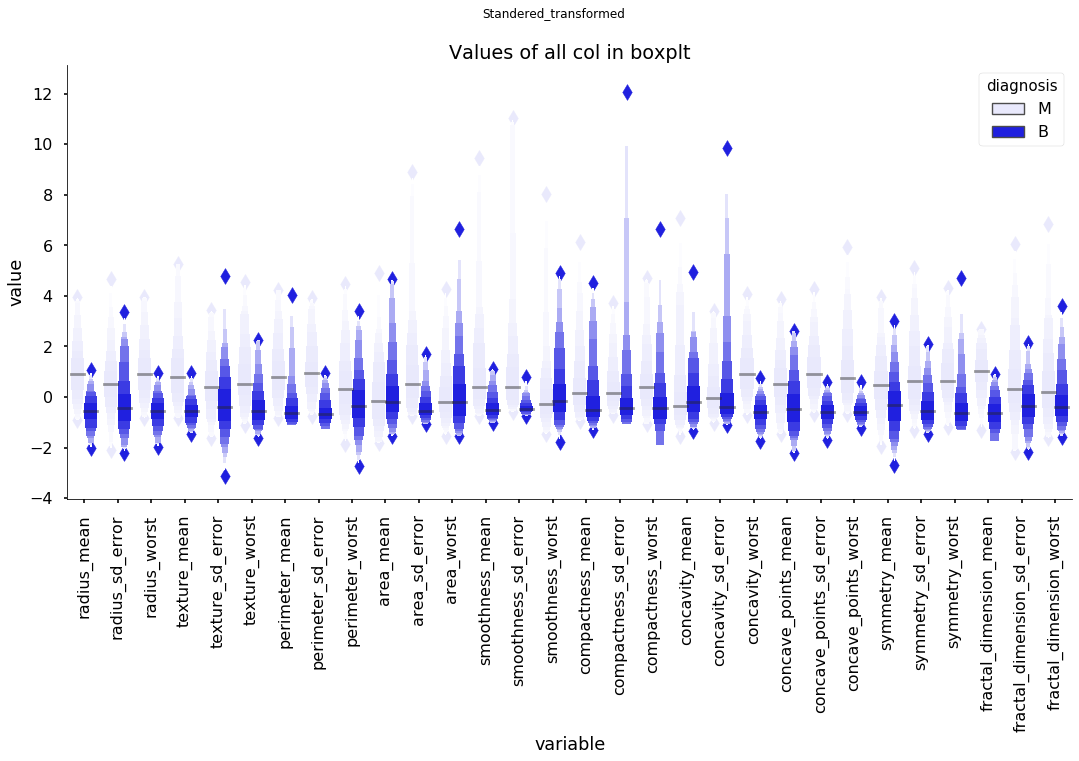

In [7]:
boxplot_custom(scale(df,StandardScaler),"Standered_transformed")

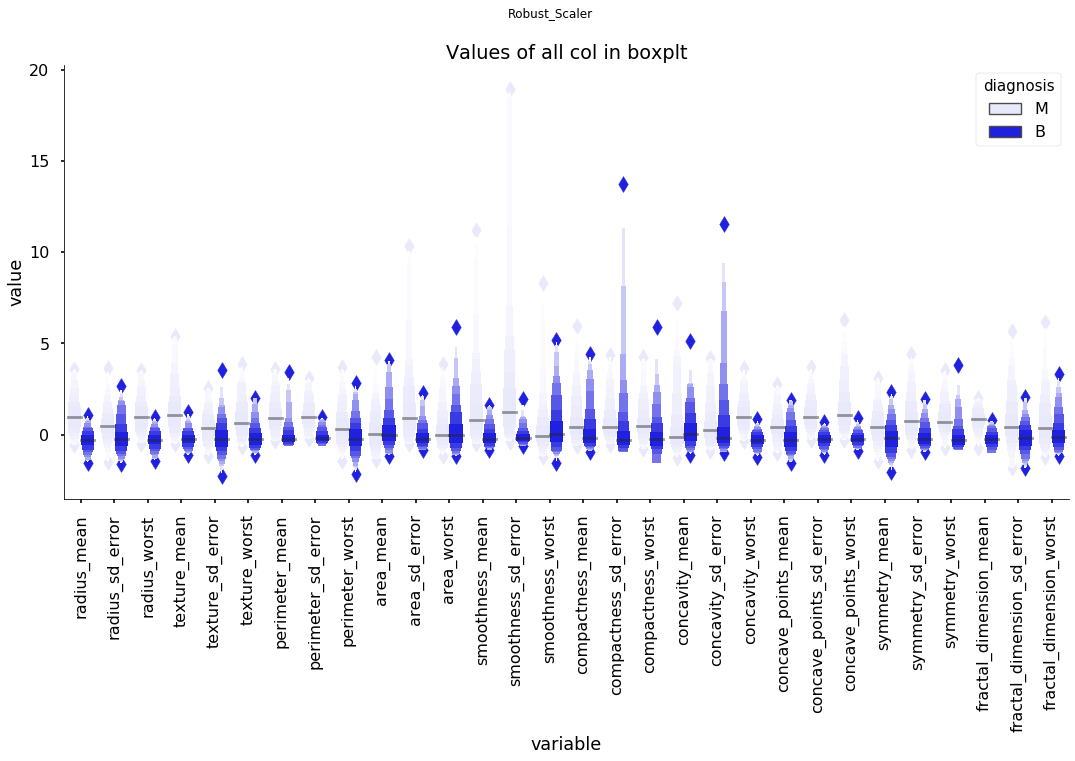

In [8]:
boxplot_custom(scale(df,RobustScaler),"Robust_Scaler")

#### Every scaler has the average scale and variability scale effect.

#### The standard scaler includes the whole dataset in the mean and variability scalers it uses the std to scale variability
#### for that the features with outliers values are shrieked more than it's been in the robust scaler.
#### That change affects the relation between the different features and change the values distribution on almost all features.

#### More clarification:

#### The standard scaler scales a record having a value equal to the mean to 0 and a value scaled to 1 was 1 std larger than the mean

#### The robust scaler scales a record having a value equal to the median to 0 and a value scaled to 1 was 1 IQR larger than the mean

#### IQR = 1.5 *(75 percentile - 25 percentile)

#### In this dataset I would use the robust scaler in that case.

In [9]:
scaled_median_df = scale(df,RobustScaler)

In [10]:
importance_rank = (scaled_median_df[scaled_median_df["diagnosis"]== "B"].iloc[:,2:]
                   .describe()
                   .loc["50%"]
                   .apply(lambda x :  abs(x)).sort_values(ascending = False))
"""
As long the median of the scaled data is =0
I'll measure the importance by calculating the absolute value of the median of diagnosis = "B" 
Which = -1*median of diagnosis ="M".
"""

'\nAs long the median of the scaled data is =0\nI\'ll measure the importance by calculating the absolute value of the median of diagnosis = "B" \nWhich = -1*median of diagnosis ="M".\n'

In [11]:
n = 5
list(importance_rank[:n].index) #Print the top n importent features

['symmetry_worst',
 'concave_points_mean',
 'radius_mean',
 'concavity_worst',
 'radius_worst']

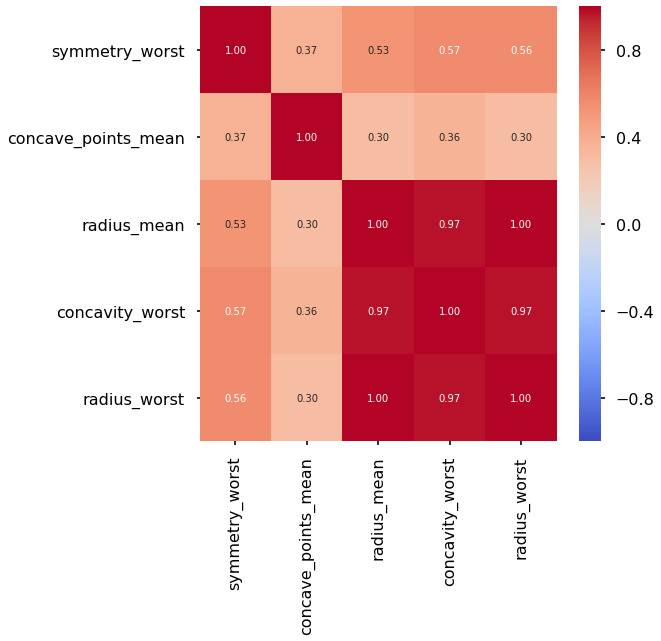

In [12]:
"""
print the top n important features correlation matrix
"""

n = 5

plt.figure(figsize=(8,8))
sns.heatmap(df.loc[:,importance_rank[:n].index].corr(),fmt='.2f',annot= True,cmap="coolwarm",vmin=-1,vmax=1);


#### I would say the first 3 features in importance_rank are the most important which are ['symmetry_worst', 'concave_points_mean', 'radius_mean']
#### because the median between the diagnosis are highly variant and the correlation between them are acceptable the 4th and the 5th are good but they replicating the 3rd.

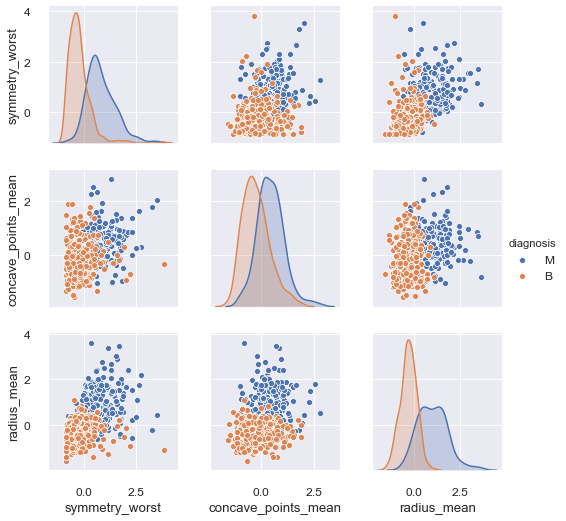

In [13]:
sns.set(font_scale=1.1)
sns.pairplot(scaled_median_df.loc[:,list(importance_rank[:3].index)+["diagnosis"]], hue= "diagnosis");

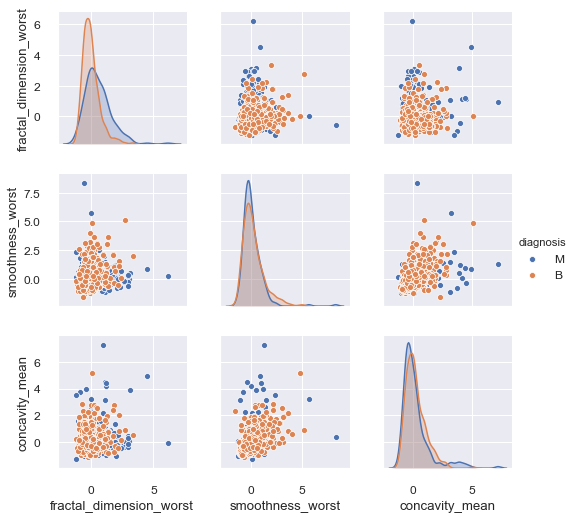

In [14]:
#to confirm lower ranked features has no significant impact to the diagnosis
sns.set(font_scale=1.1)
sns.pairplot(scaled_median_df.loc[:,list(importance_rank[25:28].index)+["diagnosis"]], hue= "diagnosis");

In [15]:
def bootstrap_samples (data,size = 1 ,random_state =None ):
    """
    This function return a data frame of records bootstrapped from an input DataFrame
    
    input
    ____________
    data: a data frame to sample from
    size: the size of the generated DataFrame comparing to the size of the original DataFrame (Recommended between 1 and 3)
    default value. = 1
    Random state
    If int, random_state is the seed used by the random number generator; 
    If None, the random number generator is the RandomState instance used by np.random.
    """
    count = data.shape[0]-1
    from numpy.random import RandomState
    r_state = RandomState(random_state)
    idx = r_state.randint(0, count-1, size=count*size)
    return pd.DataFrame(map(lambda x:data.iloc[x], idx))

#### If I'm requested to build two classification models I would go with random forest and XGboost

In [16]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues,annot_kws= {"fontsize":20})
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [17]:
y = np.array(scaled_median_df.loc[:,"diagnosis"].apply(lambda x : 1 if x== "M" else 0)).reshape(-1, 1)
X = np.array(scaled_median_df.iloc[:,2:])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2,stratify=y)

### To reduce the probability of having an overfitted model I'll perform 5 K-fold
### My evaluation metric would be recall but since False negatives can be fatal.
### Also I'll consider the log_loss because the data set is not large enough I would prefer the model with higher probabilities towards the right prediction. Just to mention the lower log_loss the better

In [ ]:
# Identifying the hyperparameter for grid search to find out the best model and then fitting the random forest model
hyper_param_grid = {'max_depth': [10,20,50,100],
                   'n_estimators': [1000,5000],
                    'bootstrap': [True, False],
                    'max_features': ['auto', 'sqrt'],
                     'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]}
rf = GridSearchCV(RandomForestClassifier(), hyper_param_grid, cv = 5,n_jobs=-1 ,verbose = 1)
rf.fit(X_train, y_train)
# with open("RF_models_1.pickle","wb")as f:
#     pickle.dump(rf,f )

In [18]:
# with open("RF_models_1.pickle","rb")as f:
#     rf= pickle.load(f )

In [ ]:
#Printing the main evaluation matrixes
print("Training accurecy: {:6.2f}%".format(100*rf.score(X_train, y_train)))
print("Test set accurecy: {:6.2f}%".format(100*rf.score(X_test, y_test)))
print("precision_score {:6.2f}%".format(100*precision_score(y_test, rf.best_estimator_.predict(X_test))))
print("recal_score {:6.2f}%".format(100*recall_score(y_test, rf.best_estimator_.predict(X_test))))
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, rf.predict_proba(X_test))), end = "\n"+"-"*20+"\n")

#printing the grid search results
pp.pprint(rf.cv_results_)

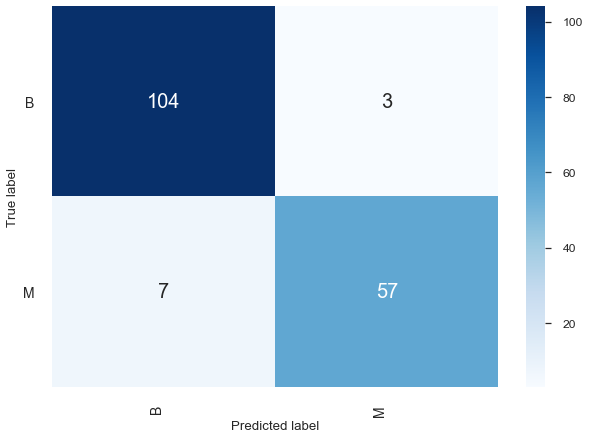

In [20]:
rforest_confusion = confusion_matrix(y_test, rf.predict(X_test))
print_confusion_matrix(rforest_confusion,["B","M"]); #print confusion matrix of Random Forest model

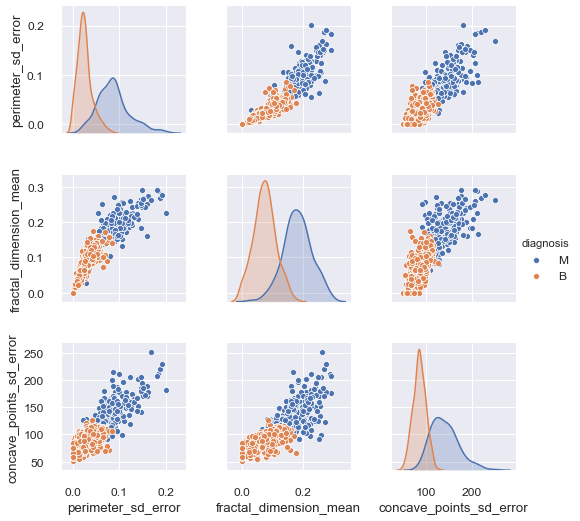

In [21]:
# select most 3 important features and plot their initial values

top_3_rf = list(df.iloc[1,(rf.best_estimator_.feature_importances_).argsort()[::-1][:3]+2].index)

sns.set(font_scale=1.1)
sns.pairplot(df.loc[:,top_3_rf+["diagnosis"]],hue = "diagnosis");

In [ ]:
# Identifying the hyperparameter for grid search to find out the best model and then fitting the XGboost model
hyper_param_grid = {'max_depth': [10,15,20],
                   "learning_rate":np.arange(0.01,0.1,0.025),
                    "n_estimators":[5000,1000],
                    'bootstrap': [True, False],
                    'min_child_weight': [1, 5, 10],
                    'gamma': [0.5, 1, 2],
                    'subsample': [0.5, 1.0],
                    'colsample_bytree': [0.5 , 1.0]}
#train and fit the model
xgb = GridSearchCV(XGBClassifier(), hyper_param_grid, cv = 5,n_jobs=-1 ,verbose = 1)
xgb.fit(X_train, y_train)


#with open("xgb_models_.pickle","wb")as f:
    #pickle.dump(xgb,f)
    


In [ ]:
#Printing the main evaluation matrixes

print("Training: {:6.2f}%".format(100*xgb.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*xgb.score(X_test, y_test)))
print("precision_score {:6.2f}%".format(100*precision_score(y_test, xgb.best_estimator_.predict(X_test))))
print("recal_score {:6.2f}%".format(100*recall_score(y_test, xgb.best_estimator_.predict(X_test))))
print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, xgb.predict_proba(X_test))), end = "\n"+"-"*20+"\n")
pp.pprint(xgb.cv_results_)

In [ ]:
# save the model to save time to resotre and memory

with open("xgb_models_.pickle","wb")as f:
    #pickle.dump(xgb,f)
    xgb1 = pickle.load(f)

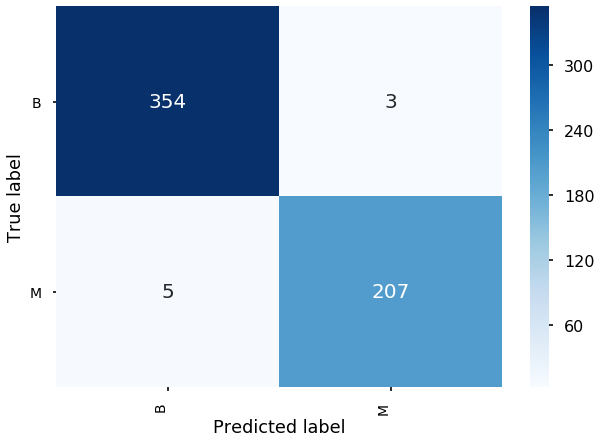

In [162]:
rforest_confusion = confusion_matrix(y_test, xgb.predict(X_test))
print_confusion_matrix(rforest_confusion,["B","M"]);

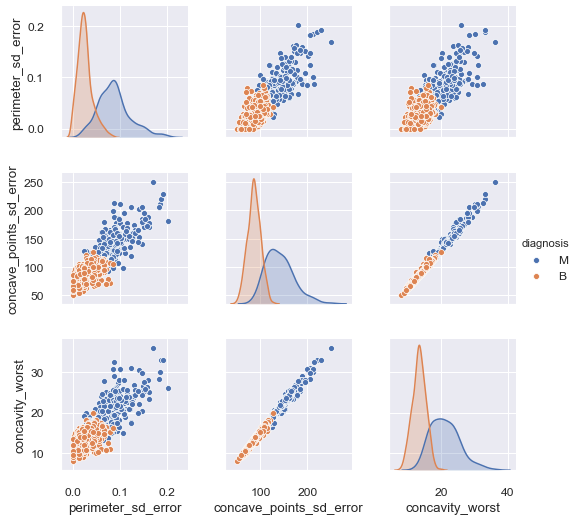

In [194]:
top_3_xgb = list(df.iloc[1,(xgb.best_estimator_.feature_importances_).argsort()[::-1][:3]+2].index)
sns.set(font_scale=1.1)
sns.pairplot(df.loc[:,top_3_xgb+["diagnosis"]],hue = "diagnosis");

In [41]:
#precision_curve_xgb, recall_curve_xgb, threshold_curve_xgb = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:,1])
precision_curve_rf, recall_curve_rf, threshold_curve_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])

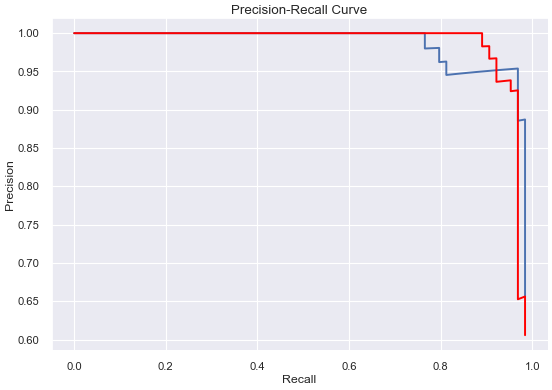

In [279]:
plt.figure(dpi=50)
plt.plot(recall_curve_rf[1:], precision_curve_rf[1:],"b",label='RF')
plt.plot(recall_curve_xgb[1:], precision_curve_xgb[1:],"red",label='XGB')


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [ ]:
AS shown on the previous graph the random forest perform better in term of recall and xgboost perform better in precision.
and the log-loss is slightly lower in xgboost 

## For technical audience

As I mentioned I would care about recall and Random forest were perform better

I'll visualize the the affect of threshold tuning in the random forest model




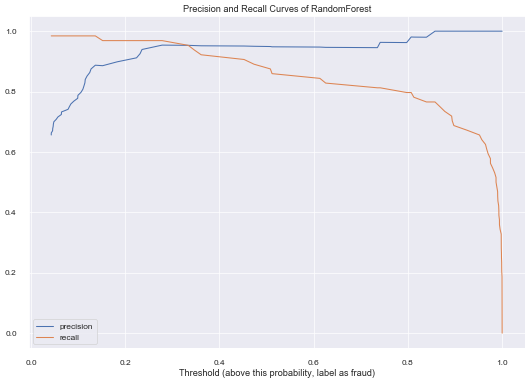


As shown the highest recall value can maintain a precision value about .9 at threshold of .175
we can get precision = recall around 0.97 at threshold 0.3
the final decision of the threshold can be determined by getting further knowledge on the domain.

future work

Extra records can be a big plus for that analysis
More features also can improve the model such as age gender ...etc
Feature engineering was not considered in this analysis due to shortage of time








In [50]:
plt.figure(dpi=50)
plt.plot(threshold_curve_rf, precision_curve_rf[1:],label='precision')
plt.plot(threshold_curve_rf, recall_curve_rf[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves of RandomForest');
print("""As I mentioned I would care about recall and Random forest were perform better\n
I'll visualize the the affect of threshold tuning in the random forest model\n
""")
plt.show()
print("""
As shown the highest recall value can maintain a precision value about .9 at threshold of .175
we can get precision = recall around 0.97 at threshold 0.3
the final decision of the threshold can be determined by getting further knowledge on the domain.

future work

Extra records can be a big plus for that analysis
More features also can improve the model such as age gender ...etc
Feature engineering was not considered in this analysis due to shortage of time





""")

## For non-technical audience

##### We used the power of data science to achieve a unique model that can diagnose people with malignant tumor quickly and with limited cost
##### the model has and accuracy of 94.15% which can Identify around 99% of malignant tumor and 90% of benign tumor.
##### it's smart enough so that it's more conservative toward benign just to not let the candidate malignant tumor in fake comfort zone.

# Part 2

In [ ]:
                                                        #Module name "student-sample-1" doesn't conform to snake_case naming style (invalid-name)
                                                        #Missing module docstring (missing-module-docstring)

#!/usr/bin/env python

import pandas as pd
import numpy as np                                      #Unused numpy imported as np (unused-import)
from sklearn import LinearRegression                    #No name 'LinearRegression' in module 'sklearn' (no-name-in-module)
                                                        #Use from sklearn.linear_model import LinearRegression instead
from sklearn.cross_validation import cross_val_score    #No name 'cross_validation' in module 'sklearn' (no-name-in-module)
                                                        #Use from sklearn.model_selection import cross_val_score instead
"""
Write docstring

"""
# Load data
d = pd.read_csv('../data/train.csv')                    #Variable name is not representitive


# Setup data for prediction
x1 = data.SalaryNormalized                              #Undefined variable 'data' (undefined-variable)
x2 = pd.get_dummies(data.ContractType)                  #Undefined variable 'data' (undefined-variable)

# Setup model
model = LinearRegression()

# Evaluate model
from sklearn.cross_validation import cross_val_score   #Unable to import 'sklearn.cross_validation' (import-error) for the 2nd time
from sklearn.cross_validation import train_test_split  #Unused train_test_split imported from sklearn.cross_validation (unused-import)
                                                       #All imports should  be placed at the top of the documnet

scores = cross_val_score(model, x2, x1, cv=1, scoring='mean_absolute_error')#model where not fitted yet
print(scores.mean())                                   #It would be better to format the output trucation to lower number of digit would look better



In [ ]:
                                                        #Module name "student-sample-2" doesn't conform to snake_case naming style (invalid-name)
#!/usr/bin/env python

import pandas as pd
import numpy as np                                      #Unused numpy imported as np (unused-import)
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score    #No name 'cross_validation' in module 'sklearn' (no-name-in-module)

"""
Write docstring

"""

# Load data
data = pd.read_csv('../data/train.csv')


# Setup data for prediction
y = data.SalaryNormalized
X = pd.get_dummies(data.ContractType)                    # when you try to predict by catigorical variable drop one of the categories  
                                                         # it can be done by setting drop_first = True
# Setup model
model = LinearRegression()

# Evaluate model
scores = cross_val_score(model, X, y, cv=5, scoring='mean_absolute_error') # model where not fitted yet.
print(scores.mean())                                    #It would be better to format the output trucation to lower number of digit would look better


